# Simulated IRT Data Generation
To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature, because these at least have some history/credibility as model data.

In [16]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
import cluster.cntree.cntree
import logging
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import sklearn.cluster
from kmodes.kmodes import KModes
from numpy.linalg import norm, svd
from scipy.stats import invgamma

%load_ext autoreload
%autoreload 2

level = logging.DEBUG
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Number of persons.
P = 1000
# Number of items.
I = 40
# Number of latent ability dimensions (sub-scales).
C = 5
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0.25

In [18]:
# Generate latent ability distribution variances.
alpha_theta, beta_theta = 1, 1
rv = invgamma(a=alpha_theta, scale=beta_theta)
v = rv.rvs(C)
print(v)

[0.71816873 1.70992459 0.22041305 1.52790214 1.04790698]


(1000, 5)


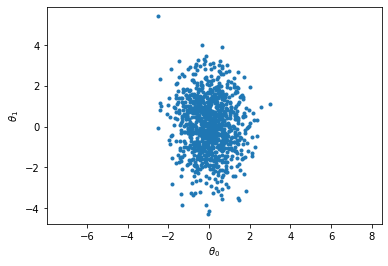

In [19]:
# Generate normally distributed student latent abilities. theta_c ~ N(0, invgamma(a_c,b_c))
cov = np.diag(v)
theta = np.random.multivariate_normal(np.zeros((C,)), cov, P)
print(theta.shape)
plt.plot(theta[:,0], theta[:,1], '.')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.axis('equal')
plt.show()

In [20]:
# Generate item difficulty parameters.
# Discrimination is uniform[0.5, 1.5].
a = np.random.random(size=(I,)) + 0.5
# Difficulty is equally spaced from -3 to 3.
b = np.linspace(-3, 3, num=I)
# Item i measures sub-scale c[i]. Select about the same number of items per subscale,
# then randomly permute the item order.
c = np.random.permutation(np.matlib.repmat(np.arange(C, dtype=int), int(np.ceil(I/C)), 1).ravel()[:I])
print(a)
print(b)
print(c)

[1.38705329 1.22033123 0.93560942 1.47021889 0.61805918 1.04135676
 0.58262913 1.03112438 0.51404238 0.80071313 0.96903444 1.08163228
 0.60124619 0.60798828 0.84949385 1.25465113 1.00287414 1.24783437
 1.0422811  1.44224903 0.61949403 0.52396593 1.07273797 0.71210571
 0.59411429 1.3587734  1.36645698 0.76981035 1.49550669 1.12317936
 1.31097899 1.24698189 0.73278117 1.17645965 1.47635883 0.5756575
 1.34816058 0.6679953  0.55500298 1.35676884]
[-3.         -2.84615385 -2.69230769 -2.53846154 -2.38461538 -2.23076923
 -2.07692308 -1.92307692 -1.76923077 -1.61538462 -1.46153846 -1.30769231
 -1.15384615 -1.         -0.84615385 -0.69230769 -0.53846154 -0.38461538
 -0.23076923 -0.07692308  0.07692308  0.23076923  0.38461538  0.53846154
  0.69230769  0.84615385  1.          1.15384615  1.30769231  1.46153846
  1.61538462  1.76923077  1.92307692  2.07692308  2.23076923  2.38461538
  2.53846154  2.69230769  2.84615385  3.        ]
[4 1 2 2 2 1 0 1 2 4 0 0 0 3 3 3 4 0 4 0 2 2 3 2 1 4 3 3 0 1 1 3 

In [21]:
# Generate item responses (the observed data).
t = np.exp(-a*(theta[:,c] - b))
p_correct = asym + (1-asym)*(t/(1+t))
X = np.random.binomial(1, p=p_correct)

## Hierarchical Person Clustering

In [29]:
x = X.astype(float)
print(x.shape)
tree = cluster.cntree.cntree.CNTree(
    max_cluster_radius=0, max_cluster_size=2, debug=1,
    initial_branch_factor=2*C, initial_num_local_iters=0)
clustering = tree.cluster(x)

INFO     	center (1, 40)
INFO     	Created level index 0 size 1 center (1, 40)
DEBUG    root Level 0[size=1,num_neighbors=1]
INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
DEBUG    parent.cluster_size [1000]
DEBUG    parent.radius [2.76880624]
DEBUG    large_large [0]
DEBUG    large_compact []
DEBUG    small []
INFO     	center (10, 40)
INFO     	Created level index 1 size 10 center (10, 40)
DEBUG    Initialized Level 1[size=10,num_neighbors=7]
DEBUG    Global iteration 0
DEBUG    	Build cluster neighborhoods


(1000, 40)
size 1
branch_factor 10
refinement_group [(array([0]), 10), (array([], dtype=int64), 2), (array([], dtype=int64), 1)] child size 10
parent of (10,)
size 10
_build_cluster_nbhrs Level 1[size=2,num_neighbors=7] (2, 40)


IndexError: index 2 is out of bounds for axis 0 with size 2

 ## Item Clustering into Classes

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters=C, random_state=0).fit(X.transpose())
print(kmeans.labels_)
#print(kmeans.cluster_centers_)
#print(kmeans.n_iter_)
#print(kmeans.inertia_)

In [ ]:
km = KModes(n_clusters=C, init='Huang', n_init=5, verbose=0)
clusters = km.fit_predict(X.transpose())
#print(km.cluster_centroids_)
print(km.labels_)
print(km.n_iter_)
print(km.cost_)

In [ ]:
print(c)

In [ ]:
import pandas as pd
pd.options.display.width = 1000
pd.options.display.precision = 3
j = np.where(c == 0)[0]
k = np.where(c == 1)[0]
i = np.concatenate((j, k))
print(j)
print(k)
xi = pd.DataFrame(X[:,i])
xi.corr()

This shows that it's not easy to recover the classes from responses, since items that measure the same dimension are not necessarily highly correlated. For now, we will assume the apriori knownledge of $c$, the correspondence between items and dimensions. 

In [ ]:
tree = cntree.CNTree(max_levels=20, max_cluster_radius=max_cluster_radius, max_cluster_size=max_cluster_size, metric="abs_cos2", debug=1)
clustering = tree.cluster(y_normalized)


In [ ]:
# Initial Guess for $\theta$

In [ ]:
# Initial guess for theta_p^c: fraction of correct responses of person p to items measuring
# sub-scale c.
theta_init = np.array([np.mean(X[:, np.where(c == d)[0]], axis=1) for d in range(C)])

In [ ]:
u, s, vh = svd(X)

In [ ]:
plt.plot(s, 'bo-')

In [ ]:
print(vh.shape)
for r in range(1, X.shape[1] + 1, 5):
    P = vh[:r].transpose()
    print(r, norm(X - (X.dot(P)).dot(P.transpose())) / norm(X))

r = 5
P = vh[:r].transpose()
t = X.dot(P)
X_reconstructed = t.dot(P.transpose())
print(X.shape, P.shape, XC.shape)
print(P[:3])
print(t[:4])
print(X[3:])
print(X_reconstructed[3:])

In [ ]:
np.mean(t, axis=0)

In [ ]:
np.mean(X, axis=0)